In [1]:
import nltk
from pprint import pprint
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from collections import Counter
from MulticoreTSNE import MulticoreTSNE as TSNE
from operator import itemgetter

# Against Tweets

# Format Data 

In [2]:
# Import data and convert to list
df = pd.read_excel('/Users/bendavies/Documents/Python /Twitter Webscraping/Analysis Scripts for Thesis/Excel Files for Thesis/Unsupportive_Tweets_For_Johnson.xlsx')
text = df['tweetText'].tolist()

# Import stop words and extend to inlcude extra terms
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['pm', 'boris', 'prime', 'minister', 'ruling', 'court', 'prorogue', 'prorogation', 
                  'ruled', 'supreme', 'johnson', 'judgement'])

# Create function to normalize data
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words] 
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)  # Vectorize function so can be applied to whole corpus
norm_corpus = normalize_corpus(text)  # Create normalized corpus

# Create Feature Vectors

In [3]:
# Create BoW model
# Max_df = remove words in more than 60% of documents
# Min_df = remove words that appear in less than X% of documents or X number of documents
cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.6, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)  # BoW matrix

# Create similarity matrix based on BoW model
cosine_sim_features = cosine_similarity(cv_matrix)

# Run Initial KMeans Models - Determine Best K

Loop through different values of k and plot inertia - use to determine inital best number of k

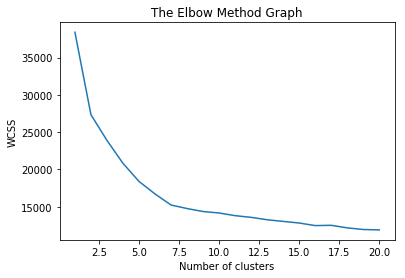

In [40]:
wcss=[]  # Store ineteria scores

for i in range(1,21): 
    km = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10, random_state=0)
    # i above is between 1-20 numbers. init parameter is the random initialization method  
    # we select kmeans++ method. max_iter parameter the maximum number of iterations there can be to 
    # find the final clusters when the K-meands algorithm is running. we enter the default value of 300
    # the next parameter is n_init which is the number of times the K_means algorithm will be run with
    # different initial centroid.
    
    km.fit(cosine_sim_features)  # Fit model
    
    # kmeans inertia_ attribute is:  Sum of squared distances of samples 
    # to their closest cluster center. A measure of goodness for the model
    wcss.append(km.inertia_)  
        


#Plot the elbow graph
plt.plot(range(1,21),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Run KMeans model based on best k

In [4]:
NUM_CLUSTERS = 7  # Choose based on eblow plot above

# Create model
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=100, n_init=50, random_state=42).fit(cosine_sim_features)

# View count of the number of tweets in each cluster
Counter(km.labels_)

Counter({1: 1041, 2: 110, 6: 152, 4: 176, 5: 178, 0: 54, 3: 215})

In [5]:
# If needed, create dataframe to view text for each cluster
df = pd.DataFrame(text, columns = ['text'])  # Create dataframe with original text
df['Norm_Text'] = norm_corpus  # Add normalized text
df['Cluster_Labels'] = km.labels_  # Add labels
df[df['Cluster_Labels'] == 5].head(10)  # View text under a specific label

,text,Norm_Text,Cluster_Labels
12,the first duty of government is to uphold the ...,first duty government uphold law tries duck we...,5
16,you wont be deterred by the law,wont deterred law,5
41,follow the law dont be a dictator i am so sorr...,follow law dont dictator sorry disappointed yo...,5
49,resignyou lied to the queen and broke the law ...,resignyou lied queen broke law land,5
63,you broke the law and 11 senior judges are una...,broke law 11 senior judges unanimous law,5
81,so erm he broke the law what does that mean no...,erm broke law mean asking friend,5
86,you fought the law and the law won i guess you...,fought law law guess race run resignborisjohnson,5
89,boris fought the law and the law won,fought law law,5
98,you broke the law you need to get a deal throu...,broke law need get deal parliament leave oct 3...,5
114,on what planet do you get to disagree with the...,planet get disagree matters law mean ffs,5


# Remove Cluster with Largest Number of Tweets

Based on the initial kmeans model, the number of tweets in each cluster is heavily skewed. E.g. Cluster number 1 contains 1190 tweets - more than half. Upon closer analysis, these tweets tend to overlap with themes from the other clusters. Therefore determine that this large cluster is noise - tweets that contain mixed or overlapping clusters and don't belong in any one specific cluster. 

We therefore remove these tweets from the analysis, and then re-run the KMeans model using one less cluster than the original model. This gives clearer tweet clusters

In [6]:
# Put noise points in separate variable for supplementary analysis 
df2 = df[df['Cluster_Labels'] == 1]
df2

,text,Norm_Text,Cluster_Labels
0,please do give your legal analysis of why you ...,please give legal analysis disagree ears,1
5,hi boris you are a liar you have a history of ...,hi liar history lying pattern lying behaviour ...,1
6,call for a general election says bring it on l...,call general election says bring lets see vote...,1
8,it is simply not possible to have any less res...,simply possible less respect disdain person ut...,1
9,you should be ashamed,ashamed,1
...,...,...,...
1917,you did get owned though,get owned though,1
1918,e sticazzi,e sticazzi,1
1919,agreed,agreed,1
1922,prorogue again for a queens speech,queens speech,1


In [31]:
# Create new dataset removing largest cluster (noise)

new_text = df[df['Cluster_Labels'] != 4]  # Create new dataframe of every cluster other than 2 (the noise cluster)
new_text = new_text['Norm_Text'].tolist()  # Convert new (normalised) text to list

# Recreate feature vectors from new corpus and re-run KMeans

In [32]:
# Create Bow Model
cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.6, stop_words=stop_words)
cv_matrix = cv.fit_transform(new_text)  # Fit count vectroizer to new text

# Recreate similarity matrix from new BoW model
cosine_sim_features = cosine_similarity(cv_matrix)

# Rerun KMeans using k = one less than previous k
NUM_CLUSTERS = 6
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=100, n_init=50, random_state=42).fit(cosine_sim_features)
print(Counter(km.labels_))

Counter({2: 213, 3: 180, 0: 176, 5: 172, 1: 90, 4: 54})


# Analysis of Clusters 

# Visualise Clusters on Plot

The BoW vector matrix is sparse - mostly contains 0's. This produces issues for plotting the tweet clusters in vector space. We use TSNE to redcue the dimensionality of the original sparse matrix into a dense 2-D matrix (similar to prinicipal components analysis). This allows the clusters to be plotted

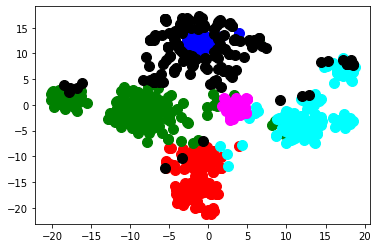

In [33]:
# Initalize tsne model. n_components sets dimensions of the space (2= 2-D)
# n_jobs sets number of processes to be run (-1 = run all)
tsne = TSNE(n_components=2, n_jobs=-1, random_state=0)
matrix_2d = tsne.fit_transform(cv_matrix.todense())  # Convert BoW model to 2D matrix

x = matrix_2d[:, 0]  # Get x-axis of matrix (used for plotting)
y = matrix_2d[:,1]  # Get y axis of matrix
labels = km.labels_  # Labels of the k means clusters

# Below we set each cluster with a specific cluster (helpful to identify topics of overlapping clusters)
plt.scatter(matrix_2d[labels==0, 0], matrix_2d[labels==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(matrix_2d[labels==1, 0], matrix_2d[labels==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(matrix_2d[labels==2, 0], matrix_2d[labels==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(matrix_2d[labels==3, 0], matrix_2d[labels==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(matrix_2d[labels==4, 0], matrix_2d[labels==4, 1], s=100, c='magenta', label ='Cluster 5')
plt.scatter(matrix_2d[labels==5, 0], matrix_2d[labels==5, 1], s=100, c='black', label ='Cluster 6')
plt.show()

From the keyphrase analysis below we can see that cluster 2 (blue) and cluster 4 (cyan) both concern issues of resigning, hence the overlap

# KeyPhrase analysis of clusters

In [7]:
# Create functions
# Create new dataframe from new text and labels
new_df = pd.DataFrame(new_text, columns = ['text'])
new_df['Cluster'] = labels
new_df['CleanedTweets'] = new_df['text'].apply(normalize_document)

# Create functions for extracting keyphrases
def compute_ngrams(sequence, n):
    return list(zip(*(sequence[index:] for index in range(n))))

def flatten_corpus(corpus):
    return ' '.join([document.strip()
                     for document in corpus])

def get_top_ngrams(corpus, ngram_val=1, limit=5):
    corpus = flatten_corpus(corpus)
    tokens = nltk.word_tokenize(corpus)
    ngrams = compute_ngrams(tokens, ngram_val)
    ngrams_freq_dist = nltk.FreqDist(ngrams)
    sorted_ngrams_fd = sorted(ngrams_freq_dist.items(),
                              key=itemgetter(1), reverse=True)
    sorted_ngrams = sorted_ngrams_fd[0:limit]
    sorted_ngrams = [(' '.join(text), freq)
                     for text, freq in sorted_ngrams]
    return sorted_ngrams

NameError: name 'new_text' is not defined

# Unigrams

In [36]:
# Loop through each cluster and print top 10 trigram phrases
for i in range(0, 6):
    print('Getting top phrases for cluster:', i+1)
    print('-' *80)
    print(get_top_ngrams(corpus=new_df['CleanedTweets'][new_df['Cluster'] == i], ngram_val=1,limit=10))
    print('-' *80)

Getting top phrases for cluster: 1
--------------------------------------------------------------------------------
[('brexit', 211), ('nothing', 92), ('said', 37), ('thought', 35), ('parliament', 33), ('proroguing', 26), ('queen', 15), ('deal', 12), ('youre', 11), ('say', 11)]
--------------------------------------------------------------------------------
Getting top phrases for cluster: 2
--------------------------------------------------------------------------------
[('resign', 130), ('crook', 3), ('buffoon', 2), ('ffs', 1), ('man', 1), ('humility', 1), ('resignboris', 1), ('getborisout', 1), ('protofascist', 1), ('drivel', 1)]
--------------------------------------------------------------------------------
Getting top phrases for cluster: 3
--------------------------------------------------------------------------------
[('people', 254), ('british', 67), ('parliament', 25), ('brexit', 24), ('leave', 23), ('eu', 21), ('deal', 21), ('dont', 20), ('referendum', 19), ('one', 18)]
---

# Bigrams

In [37]:
# Loop through each cluster and print top 10 trigram phrases
for i in range(0, 6):
    print('Getting top phrases for cluster:', i+1)
    print('-' *80)
    print(get_top_ngrams(corpus=new_df['CleanedTweets'][new_df['Cluster'] == i], ngram_val=2,limit=10))
    print('-' *80)

Getting top phrases for cluster: 1
--------------------------------------------------------------------------------
[('nothing brexit', 82), ('parliament nothing', 19), ('proroguing parliament', 16), ('said nothing', 14), ('thought nothing', 13), ('brexit said', 9), ('thought proroguing', 9), ('wasnt brexit', 8), ('brexit thought', 8), ('queens speech', 7)]
--------------------------------------------------------------------------------
Getting top phrases for cluster: 2
--------------------------------------------------------------------------------
[('resign resign', 96), ('resign crook', 3), ('crook resign', 3), ('resign buffoon', 2), ('buffoon resign', 2), ('ffs resign', 1), ('resign man', 1), ('man resign', 1), ('resign humility', 1), ('humility resign', 1)]
--------------------------------------------------------------------------------
Getting top phrases for cluster: 3
--------------------------------------------------------------------------------
[('british people', 57), ('pe

# Trigrams

In [35]:
# Loop through each cluster and print top 10 trigram phrases
for i in range(0, 6):
    print('Getting top phrases for cluster:', i+1)
    print('-' *80)
    print(get_top_ngrams(corpus=new_df['CleanedTweets'][new_df['Cluster'] == i], ngram_val=3,limit=10))
    print('-' *80)

Getting top phrases for cluster: 1
--------------------------------------------------------------------------------
[('parliament nothing brexit', 19), ('said nothing brexit', 14), ('proroguing parliament nothing', 12), ('thought nothing brexit', 11), ('ha ha ha', 6), ('brexit said nothing', 5), ('thought proroguing parliament', 5), ('thought said nothing', 4), ('proroguing nothing brexit', 4), ('thought proroguing nothing', 4)]
--------------------------------------------------------------------------------
Getting top phrases for cluster: 2
--------------------------------------------------------------------------------
[('resign resign resign', 71), ('resign resign crook', 3), ('resign crook resign', 3), ('resign resign buffoon', 2), ('resign buffoon resign', 2), ('buffoon resign resign', 2), ('ffs resign man', 1), ('resign man resign', 1), ('man resign humility', 1), ('resign humility resign', 1)]
--------------------------------------------------------------------------------
Gett

From the analysis, it looks like there are 6 clusters that have some overlap between them

Cluster 1
- Concerned with brexit having nothing to do with suspending parliament

Cluster 2
- Calls for Boris to resign, specifically on the basis that he lied to the queen and broke the law

Cluster 3
- Concerned with the British people. From further looking at whole tweets from this cluster, can see that this cluster is specifically talking about the fact that Brexit vote doesn't reflect will of british people

Cluster 4
- General calls for resignation

Cluster 5
- Tweets referring to Boris as a liar

Cluster 6
- Concerned with Boris breaking the law

Clusters 5 and 6 generally focussing on aspects of the transgression (lying and breaking law)

## Supp Analysis for Agaisnt Tweets

Analysis of Noise Points

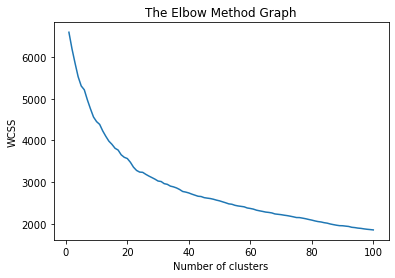

In [15]:
# Create functions for extracting keyphrases
def compute_ngrams(sequence, n):
    return list(zip(*(sequence[index:] for index in range(n))))

def flatten_corpus(corpus):
    return ' '.join([document.strip()
                     for document in corpus])

def get_top_ngrams(corpus, ngram_val=1, limit=5):
    corpus = flatten_corpus(corpus)
    tokens = nltk.word_tokenize(corpus)
    ngrams = compute_ngrams(tokens, ngram_val)
    ngrams_freq_dist = nltk.FreqDist(ngrams)
    sorted_ngrams_fd = sorted(ngrams_freq_dist.items(),
                              key=itemgetter(1), reverse=True)
    sorted_ngrams = sorted_ngrams_fd[0:limit]
    sorted_ngrams = [(' '.join(text), freq)
                     for text, freq in sorted_ngrams]
    return sorted_ngrams


new_text = df2['Norm_Text'].tolist()  # Convert new (normalised) text to list
cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.6, stop_words=stop_words)
cv_matrix = cv.fit_transform(new_text)  # BoW matrix

# Create similarity matrix based on BoW model
cosine_sim_features = cosine_similarity(cv_matrix)

wcss=[]  # Store ineteria scores

for i in range(1,101): 
    km = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10, random_state=0)
    # i above is between 1-20 numbers. init parameter is the random initialization method  
    # we select kmeans++ method. max_iter parameter the maximum number of iterations there can be to 
    # find the final clusters when the K-meands algorithm is running. we enter the default value of 300
    # the next parameter is n_init which is the number of times the K_means algorithm will be run with
    # different initial centroid.
    
    km.fit(cosine_sim_features)  # Fit model
    
    # kmeans inertia_ attribute is:  Sum of squared distances of samples 
    # to their closest cluster center. A measure of goodness for the model
    wcss.append(km.inertia_)  
        


#Plot the elbow graph
plt.plot(range(1,101),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [18]:
NUM_CLUSTERS = 20
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=100, n_init=50, random_state=42).fit(cosine_sim_features)
print(Counter(km.labels_))

new_df = pd.DataFrame(new_text, columns = ['text'])
new_df['Cluster'] = km.labels_
new_df['CleanedTweets'] = new_df['text'].apply(normalize_document)

# Unigrams 
for i in range(0, 20):
    print('Getting top unigrams for cluster: ', i+1)
    print('-' *80)
    print(get_top_ngrams(corpus=new_df['CleanedTweets'][new_df['Cluster'] == i], ngram_val=1,limit=5))
    print('-' *80)
    
for i in range(0, 20):
    print('Getting top bigrams for cluster: ', i+1)
    print('-' *80)
    print(get_top_ngrams(corpus=new_df['CleanedTweets'][new_df['Cluster'] == i], ngram_val=2,limit=5))
    print('-' *80)
    
for i in range(0, 20):
    print('Getting top trigrams for cluster: ', i+1)
    print('-' *80)
    print(get_top_ngrams(corpus=new_df['CleanedTweets'][new_df['Cluster'] == i], ngram_val=3,limit=5))
    print('-' *80)

Counter({1: 564, 2: 43, 3: 42, 12: 39, 17: 36, 7: 35, 11: 27, 0: 26, 19: 24, 16: 23, 14: 22, 6: 22, 5: 22, 9: 20, 4: 20, 13: 19, 15: 17, 10: 17, 18: 12, 8: 11})
Getting top unigrams for cluster:  1
--------------------------------------------------------------------------------
[('going', 16), ('still', 12), ('well', 4), ('know', 4), ('im', 3)]
--------------------------------------------------------------------------------
Getting top unigrams for cluster:  2
--------------------------------------------------------------------------------
[('haa', 64), ('ha', 26), ('go', 16), ('time', 15), ('vote', 15)]
--------------------------------------------------------------------------------
Getting top unigrams for cluster:  3
--------------------------------------------------------------------------------
[('get', 44), ('better', 6), ('right', 5), ('blah', 5), ('way', 5)]
--------------------------------------------------------------------------------
Getting top unigrams for cluster:  4
---

[('queen dissolve parliament', 2), ('yes try lie', 1), ('try lie make', 1), ('lie make attempts', 1), ('make attempts negotiate', 1)]
--------------------------------------------------------------------------------
Getting top trigrams for cluster:  9
--------------------------------------------------------------------------------
[('whatever pinocchio liarjohnson', 1), ('pinocchio liarjohnson liarjohnson', 1), ('liarjohnson liarjohnson borisliedtothequeen', 1), ('liarjohnson borisliedtothequeen byebyeboris', 1), ('borisliedtothequeen byebyeboris charlatan', 1)]
--------------------------------------------------------------------------------
Getting top trigrams for cluster:  10
--------------------------------------------------------------------------------
[('highest respect judiciary', 2), ('simply possible less', 1), ('possible less respect', 1), ('less respect disdain', 1), ('respect disdain person', 1)]
-----------------------------------------------------------------------------

# Tweets in Favour

# Prepare Data

Note: additional words of 'keep' 'go' and 'going' were added to stopwords due to these being frequent terms across multiple clusters

In [19]:
# Import data and convert to list
df = pd.read_excel('/Users/bendavies/Documents/Python /Twitter Webscraping/Analysis Scripts for Thesis/Excel Files for Thesis/Supportive_Tweets_For_Johnson.xlsx')
text = df['tweetText'].tolist()

# Import stop words and extend to inlcude extra terms
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['pm', 'boris', 'prime', 'minister', 'ruling', 'court', 'prorogue', 'prorogation', 
                  'ruled', 'supreme', 'johnson', 'judgement', 'keep', 'go', 'going'])

# Create function to normalize data
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words] 
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)  # Vectorize function so can be applied to whole corpus
norm_corpus = normalize_corpus(text)  # Create normalized corpus

# Create Feature Vectors

In [20]:
# Create BoW model
# Max_df = remove words in more than 60% of documents
# Min_df = remove words that appear in less than X% of documents or X number of documents
cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.6, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)  # BoW matrix

# Create similarity matrix based on BoW model
cosine_sim_features = cosine_similarity(cv_matrix)

# Determine best k

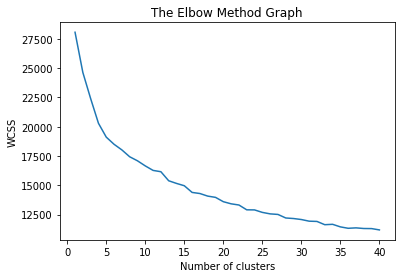

In [50]:
wcss=[]  # Store ineteria scores

for i in range(1,41): 
    km = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10, random_state=0)
    # i above is between 1-20 numbers. init parameter is the random initialization method  
    # we select kmeans++ method. max_iter parameter the maximum number of iterations there can be to 
    # find the final clusters when the K-meands algorithm is running. we enter the default value of 300
    # the next parameter is n_init which is the number of times the K_means algorithm will be run with
    # different initial centroid.
    
    km.fit(cosine_sim_features)  # Fit model
    
    # kmeans inertia_ attribute is:  Sum of squared distances of samples 
    # to their closest cluster center. A measure of goodness for the model
    wcss.append(km.inertia_)  
        


#Plot the elbow graph
plt.plot(range(1,41),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Run initial K Means model

Note - based on elbow plot for tweets in favour, unclear how many clusters should be extracted. Extract 7 clusters to be consistent with against tweets

In [21]:
NUM_CLUSTERS = 5  # Choose based on eblow plot above

# Create model
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=100, n_init=50, random_state=42).fit(cosine_sim_features)

# View count of the number of tweets in each cluster
Counter(km.labels_)

Counter({3: 1006, 4: 224, 0: 224, 2: 162, 1: 143})

In [22]:
# If needed, create dataframe to view text for each cluster
df = pd.DataFrame(text, columns = ['text'])  # Create dataframe with original text
df['Norm_Text'] = norm_corpus  # Add normalized text
df['Cluster_Labels'] = km.labels_  # Add labels
df[df['Cluster_Labels'] == 1].head(10)  # View text under a specific label

,text,Norm_Text,Cluster_Labels
18,boris never give up for these traitors they ar...,never give traitors throwing everything us sti...,1
31,the people are with you keep going,people,1
72,boris go aheadthank you for respecting the vot...,aheadthank respecting votewe people support yo...,1
79,hi boris hope you read this we the people are ...,hi hope read people still although media repor...,1
91,good news pm thank you many mps have forgotten...,good news thank many mps forgotten courts deci...,1
96,all the stuff ive seen in the news tonight has...,stuff ive seen news tonight nothing british pu...,1
111,good on you real people support you,good real people support,1
112,even people i speak to who voted to remain jus...,even people speak voted remain want job donekeep,1
131,go on boris the normal people are with you,normal people,1
146,here here i am one of the people do it for me ...,one people us way,1


# Remove largest cluster (noise)

Note: May need to change which cluster number is removed based on previous analysis

In [23]:
# Put noise points in separate variable for supplementary analysis 
df2 = df[df['Cluster_Labels'] == 3]
df2

,text,Norm_Text,Cluster_Labels
0,battle lost but not the war democracy is relia...,battle lost war democracy reliant winning day ...,3
1,good man stay strong,good man stay strong,3
6,as if some of the dickheads on here coming out...,dickheads coming thank despite absolute car cr...,3
7,boris get brexit sorted for all that voted lea...,get brexit sorted voted leave remaining even t...,3
8,yep fighting talk carry on boris,yep fighting talk carry,3
...,...,...,...
1754,reinstate the military act and we will make it...,reinstate military act make happen,3
1755,keep the faith boris,faith,3
1756,do not resign,resign,3
1757,no surrender boris,surrender,3


In [19]:
# Create new dataset removing largest cluster (noise)

new_text = df[df['Cluster_Labels'] != 3]  # Create new dataframe of every cluster other than 2 (the noise cluster)
new_text = new_text['Norm_Text'].tolist()  # Convert new (normalised) text to list

# Recreate Features and KMeans Model

In [20]:
# Create Bow Model
cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.6, stop_words=stop_words)
cv_matrix = cv.fit_transform(new_text)  # Fit count vectroizer to new text

# Recreate similarity matrix from new BoW model
cosine_sim_features = cosine_similarity(cv_matrix)

# Rerun KMeans using k = one less than previous k
NUM_CLUSTERS = 4
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=100, n_init=50, random_state=42).fit(cosine_sim_features)
print(Counter(km.labels_))

Counter({1: 222, 0: 218, 3: 162, 2: 151})


# Analyse Clusters

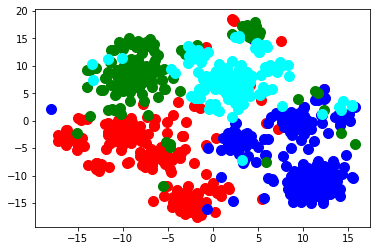

In [21]:
# Initalize tsne model. n_components sets dimensions of the space (2= 2-D)
# n_jobs sets number of processes to be run (-1 = run all)
tsne = TSNE(n_components=2, n_jobs=-1, random_state=0)
matrix_2d = tsne.fit_transform(cv_matrix.todense())  # Convert BoW model to 2D matrix

x = matrix_2d[:, 0]  # Get x-axis of matrix (used for plotting)
y = matrix_2d[:,1]  # Get y axis of matrix
labels = km.labels_  # Labels of the k means clusters

# Below we set each cluster with a specific cluster (helpful to identify topics of overlapping clusters)
plt.scatter(matrix_2d[labels==0, 0], matrix_2d[labels==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(matrix_2d[labels==1, 0], matrix_2d[labels==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(matrix_2d[labels==2, 0], matrix_2d[labels==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(matrix_2d[labels==3, 0], matrix_2d[labels==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(matrix_2d[labels==4, 0], matrix_2d[labels==4, 1], s=100, c='magenta', label ='Cluster 5')
plt.scatter(matrix_2d[labels==5, 0], matrix_2d[labels==5, 1], s=100, c='black', label ='Cluster 6')
plt.show()

# KeyPhrase Analysis

In [22]:
# Create functions
# Create new dataframe from new text and labels
new_df = pd.DataFrame(new_text, columns = ['text'])
new_df['Cluster'] = labels
new_df['CleanedTweets'] = new_df['text'].apply(normalize_document)

# Create functions for extracting keyphrases
def compute_ngrams(sequence, n):
    return list(zip(*(sequence[index:] for index in range(n))))

def flatten_corpus(corpus):
    return ' '.join([document.strip()
                     for document in corpus])

def get_top_ngrams(corpus, ngram_val=1, limit=5):
    corpus = flatten_corpus(corpus)
    tokens = nltk.word_tokenize(corpus)
    ngrams = compute_ngrams(tokens, ngram_val)
    ngrams_freq_dist = nltk.FreqDist(ngrams)
    sorted_ngrams_fd = sorted(ngrams_freq_dist.items(),
                              key=itemgetter(1), reverse=True)
    sorted_ngrams = sorted_ngrams_fd[0:limit]
    sorted_ngrams = [(' '.join(text), freq)
                     for text, freq in sorted_ngrams]
    return sorted_ngrams

# Unigram

In [24]:
# Loop through each cluster and print top 10 unigram phrases
for i in range(0, 4):
    print('Getting top phrases for cluster:', i)
    print('-' *80)
    print(get_top_ngrams(corpus=new_df['CleanedTweets'][new_df['Cluster'] == i], ngram_val=1,limit=10))
    print('-' *80)

Getting top phrases for cluster: 0
--------------------------------------------------------------------------------
[('dont', 237), ('let', 66), ('give', 58), ('please', 47), ('behind', 34), ('resign', 34), ('get', 30), ('us', 28), ('need', 28), ('brexit', 27)]
--------------------------------------------------------------------------------
Getting top phrases for cluster: 1
--------------------------------------------------------------------------------
[('get', 200), ('us', 173), ('eu', 45), ('brexit', 44), ('deal', 38), ('please', 35), ('done', 33), ('dont', 29), ('want', 19), ('leave', 19)]
--------------------------------------------------------------------------------
Getting top phrases for cluster: 2
--------------------------------------------------------------------------------
[('people', 181), ('voted', 35), ('dont', 25), ('million', 24), ('leave', 23), ('brexit', 22), ('parliament', 22), ('back', 18), ('174', 18), ('vote', 17)]
---------------------------------------------

# Bigram

In [25]:
# Loop through each cluster and print top 10 bigram phrases
for i in range(0, 4):
    print('Getting top phrases for cluster:', i)
    print('-' *80)
    print(get_top_ngrams(corpus=new_df['CleanedTweets'][new_df['Cluster'] == i], ngram_val=2,limit=10))
    print('-' *80)

Getting top phrases for cluster: 0
--------------------------------------------------------------------------------
[('dont let', 60), ('dont give', 51), ('please dont', 30), ('dont resign', 23), ('174 million', 14), ('dont want', 11), ('let us', 9), ('give dont', 9), ('people behind', 8), ('dont dare', 8)]
--------------------------------------------------------------------------------
Getting top phrases for cluster: 1
--------------------------------------------------------------------------------
[('get us', 101), ('us eu', 21), ('get done', 15), ('us get', 13), ('please get', 9), ('get brexit', 9), ('brexit done', 8), ('lets get', 7), ('us 31st', 7), ('31st oct', 6)]
--------------------------------------------------------------------------------
Getting top phrases for cluster: 2
--------------------------------------------------------------------------------
[('people voted', 20), ('174 million', 17), ('million people', 16), ('british people', 11), ('voted leave', 9), ('people s

# Trigram

In [26]:
# Loop through each cluster and print top 10 trigram phrases
for i in range(0, 4):
    print('Getting top phrases for cluster:', i)
    print('-' *80)
    print(get_top_ngrams(corpus=new_df['CleanedTweets'][new_df['Cluster'] == i], ngram_val=3,limit=10))
    print('-' *80)

Getting top phrases for cluster: 0
--------------------------------------------------------------------------------
[('please dont give', 10), ('dont let us', 9), ('dont give dont', 8), ('please dont resign', 6), ('dont let bastards', 6), ('dont dare resign', 6), ('dont give please', 5), ('dont give 174', 5), ('give 174 million', 5), ('please dont let', 4)]
--------------------------------------------------------------------------------
Getting top phrases for cluster: 1
--------------------------------------------------------------------------------
[('get us eu', 15), ('get us get', 9), ('get brexit done', 8), ('get us 31st', 6), ('please get us', 6), ('get job done', 5), ('get us dont', 5), ('us get us', 5), ('way get us', 4), ('take us eu', 4)]
--------------------------------------------------------------------------------
Getting top phrases for cluster: 2
--------------------------------------------------------------------------------
[('174 million people', 12), ('deliver peopl

Although the cluster plot shows overlapping clusters and isn't as clear cut as the agaisnt tweets, the keyphrase analysis from each cluster does provide meaningful themes:

Cluster 1:
- Seems to be about getting us out of EU

Cluster 2:
- Concerns delivering what 17.4 million people voted for in EU referendum

Cluster 3:
- Concerns telling Boris not to give up

Cluster 4:
- Concerns telling Boris that the people are behind him/he has backing of the people

Cluster 5:
- Concerns getting Brexit done

Cluster 6:
- Concerns telling Boris to stay strong


Generally these clusters can probably be grouped into 2 overarching categories: delivering Brexit and general statements of support

## Supplementary Analysis of Noise Points

Analysis of Noise Points

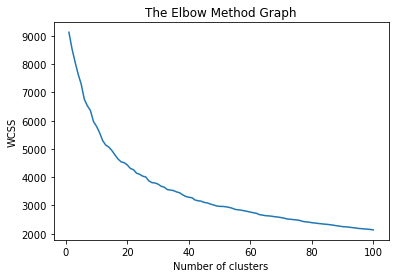

In [25]:
# Create functions for extracting keyphrases
def compute_ngrams(sequence, n):
    return list(zip(*(sequence[index:] for index in range(n))))

def flatten_corpus(corpus):
    return ' '.join([document.strip()
                     for document in corpus])

def get_top_ngrams(corpus, ngram_val=1, limit=5):
    corpus = flatten_corpus(corpus)
    tokens = nltk.word_tokenize(corpus)
    ngrams = compute_ngrams(tokens, ngram_val)
    ngrams_freq_dist = nltk.FreqDist(ngrams)
    sorted_ngrams_fd = sorted(ngrams_freq_dist.items(),
                              key=itemgetter(1), reverse=True)
    sorted_ngrams = sorted_ngrams_fd[0:limit]
    sorted_ngrams = [(' '.join(text), freq)
                     for text, freq in sorted_ngrams]
    return sorted_ngrams


new_text = df2['Norm_Text'].tolist()  # Convert new (normalised) text to list
cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.6, stop_words=stop_words)
cv_matrix = cv.fit_transform(new_text)  # BoW matrix

# Create similarity matrix based on BoW model
cosine_sim_features = cosine_similarity(cv_matrix)

wcss=[]  # Store ineteria scores

for i in range(1,101): 
    km = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10, random_state=0)
    # i above is between 1-20 numbers. init parameter is the random initialization method  
    # we select kmeans++ method. max_iter parameter the maximum number of iterations there can be to 
    # find the final clusters when the K-meands algorithm is running. we enter the default value of 300
    # the next parameter is n_init which is the number of times the K_means algorithm will be run with
    # different initial centroid.
    
    km.fit(cosine_sim_features)  # Fit model
    
    # kmeans inertia_ attribute is:  Sum of squared distances of samples 
    # to their closest cluster center. A measure of goodness for the model
    wcss.append(km.inertia_)  
        


#Plot the elbow graph
plt.plot(range(1,101),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [26]:
NUM_CLUSTERS = 18
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=100, n_init=50, random_state=42).fit(cosine_sim_features)
print(Counter(km.labels_))

new_df = pd.DataFrame(new_text, columns = ['text'])
new_df['Cluster'] = km.labels_
new_df['CleanedTweets'] = new_df['text'].apply(normalize_document)

# Unigrams 
for i in range(0, 18):
    print('Getting top unigrams for cluster: ', i+1)
    print('-' *80)
    print(get_top_ngrams(corpus=new_df['CleanedTweets'][new_df['Cluster'] == i], ngram_val=1,limit=5))
    print('-' *80)
    
for i in range(0, 18):
    print('Getting top bigrams for cluster: ', i+1)
    print('-' *80)
    print(get_top_ngrams(corpus=new_df['CleanedTweets'][new_df['Cluster'] == i], ngram_val=2,limit=5))
    print('-' *80)
    
for i in range(0, 18):
    print('Getting top trigrams for cluster: ', i+1)
    print('-' *80)
    print(get_top_ngrams(corpus=new_df['CleanedTweets'][new_df['Cluster'] == i], ngram_val=3,limit=5))
    print('-' *80)

Counter({1: 494, 10: 65, 5: 50, 7: 44, 3: 41, 15: 39, 2: 39, 4: 38, 0: 29, 12: 27, 14: 23, 8: 22, 11: 22, 6: 20, 9: 17, 17: 14, 13: 13, 16: 9})
Getting top unigrams for cluster:  1
--------------------------------------------------------------------------------
[('back', 32), ('time', 5), ('parliament', 4), ('million', 4), ('100', 3)]
--------------------------------------------------------------------------------
Getting top unigrams for cluster:  2
--------------------------------------------------------------------------------
[('vote', 20), ('deliver', 18), ('time', 16), ('election', 16), ('love', 16)]
--------------------------------------------------------------------------------
Getting top unigrams for cluster:  3
--------------------------------------------------------------------------------
[('well', 39), ('done', 18), ('said', 15), ('parliament', 3), ('31st', 3)]
--------------------------------------------------------------------------------
Getting top unigrams for cluste